In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as optimize

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    #'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# Latin Hypercube

In [3]:
def uniform_random_samples(ndata, limits):
    """Select parameters in a hypercube sampled uniformly in the range limits.
    
    Parameters
    ----------
    Ndata : int
        Number of points to select.
    limits : np.array([[x1_min, x1_max], [x2_min, x2_max], [x3_min, x3_max], ...])
        Boundaries of the hypercube.
    """
    ndim = len(limits)
    
    param_columns = []
    for i in range(ndim):
        xi_min, xi_max = limits[i]
        xis = np.random.uniform(low=xi_min, high=xi_max, size=ndata)
        param_columns.append(xis)
    
    return np.array(param_columns).T

In [4]:
def latin_hypercube(Ndata, limits):
    """Select parameters using the Latin Hypercube method.
    
    Parameters
    ----------
    Ndata : int
        Number of points to select.
    limits : np.array([[x1_min, x1_max], [x2_min, x2_max], [x3_min, x3_max], ...])
        Boundaries of the hypercube.
    """
    Nparams = len(limits)
    
    # Find indices of grid points
    point_ind_list = []
    allowed_indices = np.array([[n for n in range(Ndata)] for i in range(Nparams)])
    for n in range(Ndata):
        js = np.random.randint(Ndata-n, size=Nparams)
        point_ind = [allowed_indices[i, js[i]] for i in range(Nparams)]
        point_ind_list.append(point_ind)
        allowed_indices = np.array([np.delete(allowed_indices[i], js[i]) for i in range(Nparams)])
    
    point_ind_array = np.array(point_ind_list)
    
    # Get grid points
    grids = []
    for i in range(Nparams):
        grids.append(np.linspace(limits[i, 0], limits[i, 1], Ndata))
    
    grids_array = np.array(grids)
    
    # Get chosen points on the grid
    points = np.array([[grids_array[i, point_ind_array[n, i]] for i in range(Nparams)] for n in range(Ndata)])
    
    return points

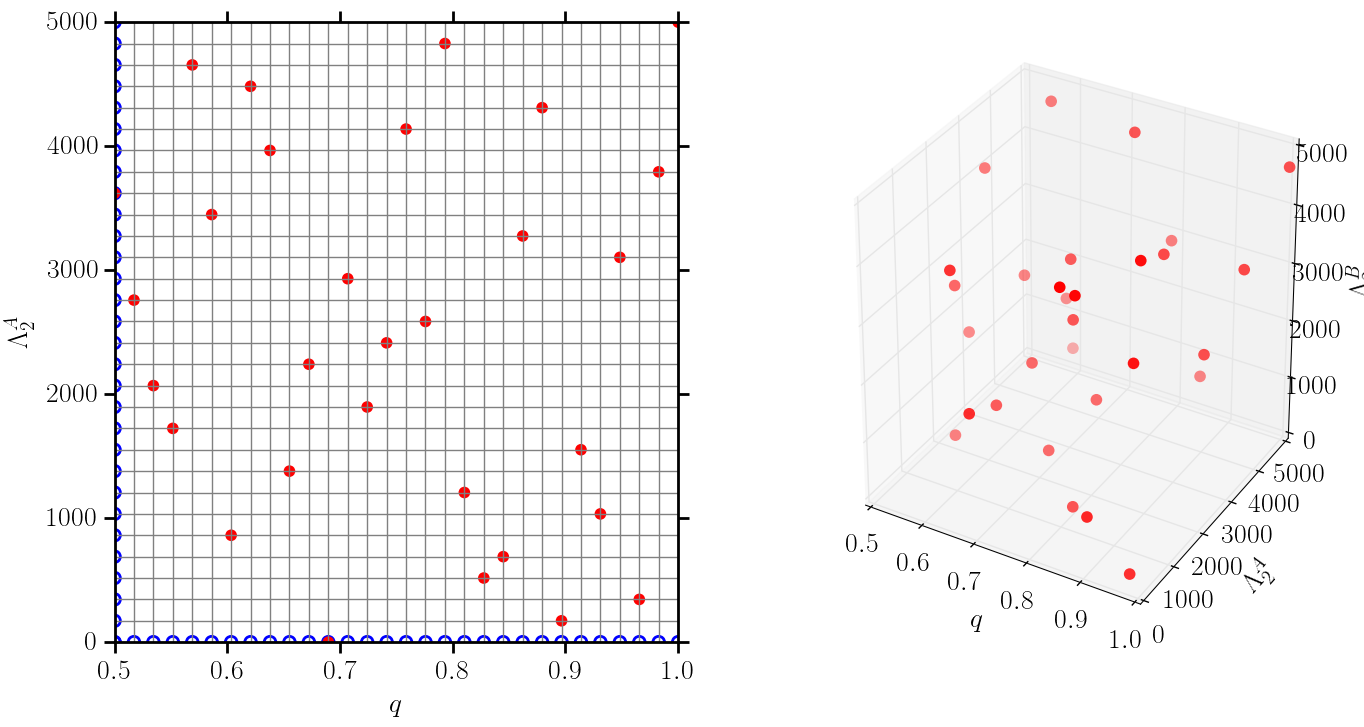

In [5]:
# Make 3d latin hypercube points
Ndata = 30
limits = np.array([[0.5, 1.0], [0, 5000], [0, 5000]])
points = latin_hypercube(Ndata, limits)


# ******* plot data *******
fig = plt.figure(figsize=(16, 8))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(121)

for p in points[:, 0]:
    axes.axvline(p, c='grey', lw=1)

for p in points[:, 1]:
    axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$q$')
axes.set_ylabel(r'$\Lambda_2^A$')


# ****** Full 3d data ******
axes = fig.add_subplot(122, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$q$', labelpad=10)
axes.set_ylabel(r'$\Lambda_2^A$', labelpad=15)
axes.set_zlabel(r'$\Lambda_2^B$', labelpad=18)

# Gaussian process class

In [6]:
class GaussianProcess(object):
    """
    """
    def __init__(self, params, y, cov, hyperparams):
        """Gaussian Process for n dimensional set of data.
        
        Parameters
        ----------
        params : array of shape (nparams, ndim).
            Parameters of sampled data.
        y : array of shape nparams.
            Data at each of the sampled parameters.
        cov : func(p1, p2, hyperparams)
            Covariance function.
        hyperparams : args
            Hyperparameters for the covariance function.
        """
        self.params = params
        self.y = y
        self.cov = cov
        self.hyperparams = hyperparams
        
        self.nparams, self.ndim = params.shape
        
        # Evaluate K
        self.K = np.array([[self.cov(p1, p2, self.hyperparams) for p2 in self.params] for p1 in self.params])
        
        # Evaluate K^{-1}
        self.Kinv = np.linalg.inv(self.K)
        
        # Evaluate (K^{-1})_{ij} y_j (returns vector of length nparams).
        self.Kinv_dot_y = np.dot(self.Kinv, self.y)
        
    def __call__(self, pst):
        """Interpolate the data at the point pst.
        
        Parameters
        ----------
        pst : array of shape ndim.
            Point p_* where you want to evaluate the function.
        
        Returns
        -------
        yst : float
            Interpolated value at the point pst.
        """
        # Evaluate vector K_*
        Kst = np.array([self.cov(pst, p1, self.hyperparams) for p1 in self.params])
        
        # Evaluate y_*
        return np.dot(Kst, self.Kinv_dot_y)
    
    def error(self, pst):
        """Estimate the interpolation error at the point pst.
        
        Parameters
        ----------
        pst : array of shape ndim.
            Point p_* where you want to evaluate the function.
        
        Returns
        -------
        sqrt(yst_var) : float
            Estimate of the interpolation error at point pst.
        """
        # Evaluate vector K_* and point K_**
        Kst = np.array([self.cov(pst, p1, self.hyperparams) for p1 in self.params])
        Kstst = self.cov(pst, pst, self.hyperparams)
        
        # Evaluate variance at y_*
        yst_var = Kstst - np.dot(Kst, np.dot(self.Kinv, Kst.T) )
        return np.sqrt(yst_var)
    
    def ln_like(self):
        """ln(likelihood) of the Gaussian Process given the hyperparameters covargs.
        Expression is the sum of 3 terms: data, complexity penalty, normalization
        """
        Kdet = np.linalg.det(self.K)
        return -0.5*np.dot(self.y.T, self.Kinv_dot_y) - 0.5*np.log(Kdet) - 0.5*self.nparams*np.log(2.0*np.pi)

In [7]:
# Class for set of GaussianProcess with common covariance function and data
# Should this be a class that inherits the methods of GaussianProcess? Is that how things work?
class GaussianProcessSet(object):
    def __init__(self, params, y, cov):
        """Gaussian Process for n dimensional set of data.
        
        Parameters
        ----------
        params : array of shape (nparams, ndim).
            Parameters of sampled data.
        y : array of shape nparams.
            Data at each of the sampled parameters.
        cov : func(p1, p2, *covargs)
            Covariance function.
        covargs : args
            Arguments for the covariance function.
        """
        self.cov = cov
        self.params = params
        self.y = y
        
    def ln_like_of_log_hyperparams(self, log10_hyperparams):
        """ln(likelihood) as a function of log10(hyperparameters).
        """
        gp = GaussianProcess(self.params, self.y, self.cov, 10.0**log10_hyperparams)
        return gp.ln_like()

    def neg_ln_like(self, log10_hyperparams):
        """-ln(likelihood) as a function of log10(hyperparameters).
        Used in optimization routines which always do minimization instead of maximization.
        """
        return -self.ln_like_of_log_hyperparams(log10_hyperparams)
    
    def optimize(self, log10_hp0):
        """
        Parameters
        ----------
        log10_hp0 : array shape nhyperparams
            Initial guess for optimal log10(hyperparams).
        """
        res = optimize.minimize(self.neg_ln_like, log10_hp0)
        return 10**res.x

# Covariance functions

In [8]:
def squared_exponential_covariance(p1, p2, hyperparams):
    """Squared exponential covariance function for n-dimensional data.
    
    Parameters
    ----------
    p1 : array with shape ndim
    p2 : array with shape ndim
    hyperparams : array with shape ndim+2 [sigma_f, sigma_n, ls0, ls1, ...]
        sigma_f : Approximately the range (ymax-ymin) of values that the data takes.
            sigma_f^2 called the signal variance.
        sigma_n : Noise term. The uncertainty in the y values of the data.
        ls0 : Length scales for the variation in dimension 0.
        
    Returns
    -------
    covariance : float
    """
    sigma_f = hyperparams[0]
    sigma_n = hyperparams[1]
    ls = hyperparams[2:]
    ndim = len(ls)
    # !!!!!!!! assert that len(p1) == len(p2) == len(hyperparams)-2 !!!!!!!! #
        
    # Noise nugget for diagonal elements
    if np.array_equal(p1, p2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    
    # Calculate the covariance
    squares = np.array([-(p1[i]-p2[i])**2 / (2*ls[i]**2) for i in range(ndim)])
    return sigma_f**2 * np.exp(np.sum(squares)) + nugget

# Testing

# 1D

In [9]:
#x = np.array([-6.0, -5.0, -3.0, 0.0, 1.2, 1.5, 1.9, 3.0, 4.0, 5.2, 6, 7])
x = np.linspace(-6.0, 7.0, 50.0)

def func(x):
    return np.sin(x*(1.0+0.05*x)) + 0.5*x + 10

sigma = 0.1
y = func(x) + np.random.normal(0.0, sigma, x.shape)

params = np.array([x]).T
hyperparams = np.array([1.0, 0.1, 1.0])
gp = GaussianProcess(params, y, squared_exponential_covariance, hyperparams)
gp.ln_like()

-324.69707875940497

(5.9589242746631381, 15.814484779937501)

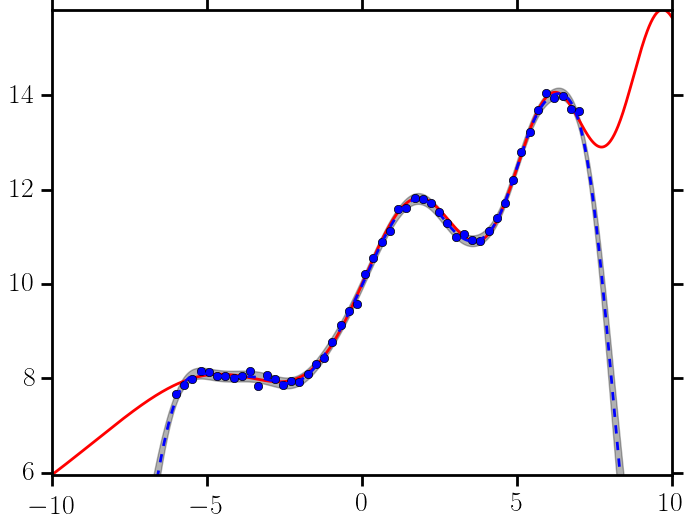

In [10]:
xall = np.linspace(-10, 10, 1000)
yall = func(xall)

xs = np.linspace(-10, 10, 1000)
ys = np.array([gp(np.array([p])) for p in xs])
ysvar = np.array([gp.error(np.array([p])) for p in xs])

fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(xall, yall, c='r', lw=2)
axes.plot(x, y, 'bo')
axes.plot(xs, ys, c='b', ls='--', lw=2)
axes.fill_between(xs, ys-ysvar, ys+ysvar, color='k', alpha=0.3)
axes.set_ylim(np.min(yall), np.max(yall))

In [639]:
gpset = GaussianProcessSet(params, y, squared_exponential_covariance)
hyperparams_opt = gpset.optimize(np.log10(hyperparams))
print hyperparams_opt

[ 7.50373467  0.11162794  2.51092254]


In [645]:
gpset.optimize(np.log10([10, 0.1, 1.0]))

array([ 7.50398898,  0.11162728,  2.51093753])

In [646]:
gpset.optimize(np.log10([5, 0.2, 2.0]))

array([ 7.50359976,  0.11162725,  2.5109213 ])

(5.9589242746631381, 15.814484779937501)

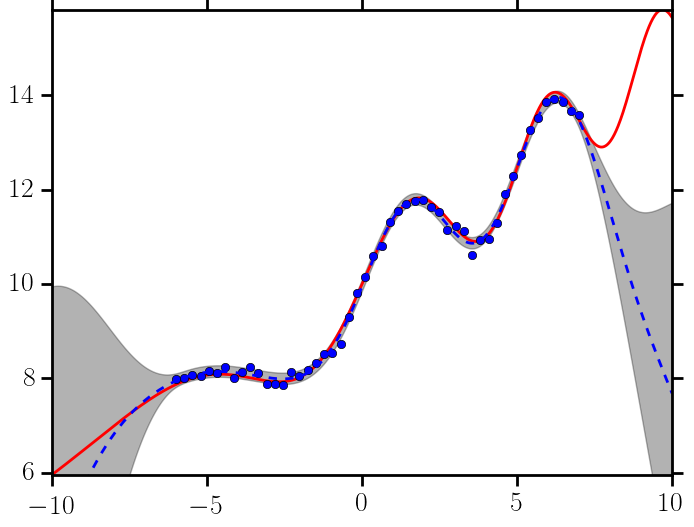

In [640]:
gp = GaussianProcess(params, y, squared_exponential_covariance, hyperparams_opt)

xall = np.linspace(-10, 10, 1000)
yall = func(xall)

xs = np.linspace(-10, 10, 1000)
ys = np.array([gp(np.array([p])) for p in xs])
ysvar = np.array([gp.error(np.array([p])) for p in xs])

fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(xall, yall, c='r', lw=2)
axes.plot(x, y, 'bo')
axes.plot(xs, ys, c='b', ls='--', lw=2)
axes.fill_between(xs, ys-ysvar, ys+ysvar, color='k', alpha=0.3)
axes.set_ylim(np.min(yall), np.max(yall))

In [641]:
log_sigma_n = np.log10(0.1)
xgrid = np.arange(0, 3, 0.1)
ygrid = np.arange(-1, 2, 0.1)
X, Y = np.meshgrid(xgrid, ygrid)
Z = np.array([[gpset.ln_like_of_log_hyperparams(np.array([X[i, j], log_sigma_n, Y[i, j]])) for j in range(len(X[0]))] for i in range(len(X))])

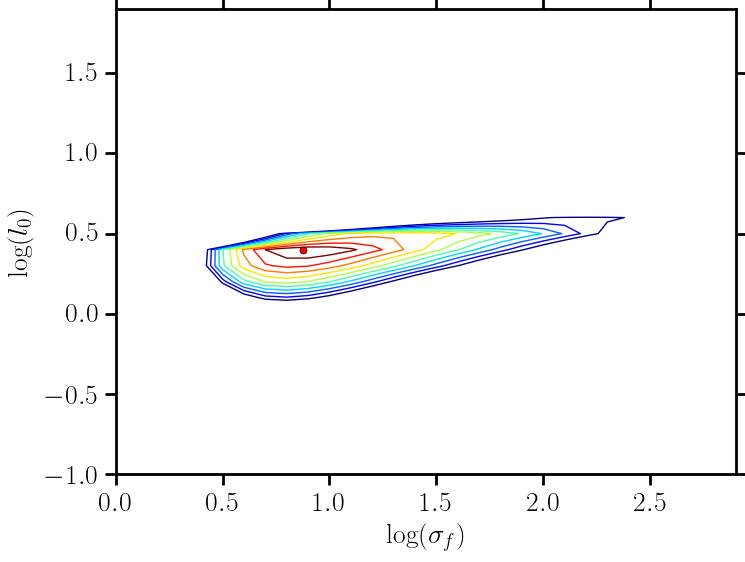

In [642]:
levels = Z.max() + np.arange(-20, 0, 2)

fig, axes = plt.subplots(figsize=(8, 6))
axes.contour(X, Y, Z, levels)
axes.plot(np.log10(hyperparams_opt[0]), np.log10(hyperparams_opt[2]), 'ro', markersize=5)
axes.set_xlabel(r'$\log(\sigma_f)$')
axes.set_ylabel(r'$\log(l_0)$')

# 2D

# Latin hypercube sampling

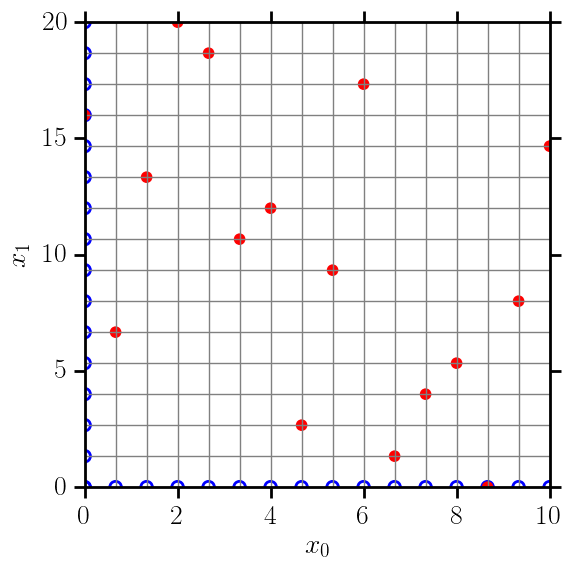

In [719]:
# Make 2d latin hypercube points
Ndata = 16
limits = np.array([[0, 10], [0, 20]])
points = latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

for p in points[:, 0]:
    axes.axvline(p, c='grey', lw=1)

for p in points[:, 1]:
    axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [1]:
params = points

# Generate data
def func(x, y):
    return 0.1*x*np.sin(x) + 0.02*y**2

data = np.array([func(params[i, 0], params[i, 1]) for i in range(len(params))])

# Construct Gaussian process
hyperparams = np.array([2.0, 0.01, 3.0, 10.0])
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams)
gp.ln_like()

NameError: name 'points' is not defined

In [721]:
gpset = GaussianProcessSet(params, data, squared_exponential_covariance)
hyperparams_opt = gpset.optimize(np.log10(hyperparams))
print hyperparams_opt

[  7.12448529e+00   2.56781833e-04   3.69760330e+00   1.80868773e+01]


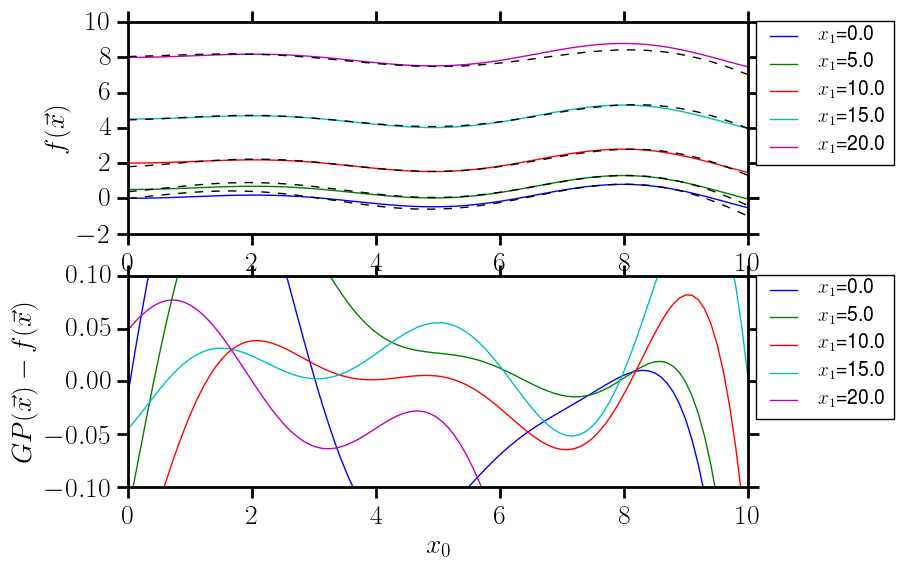

In [722]:
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams_opt)

fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    interp = np.array([gp(p) for p in ps])
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))


ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Random sampling

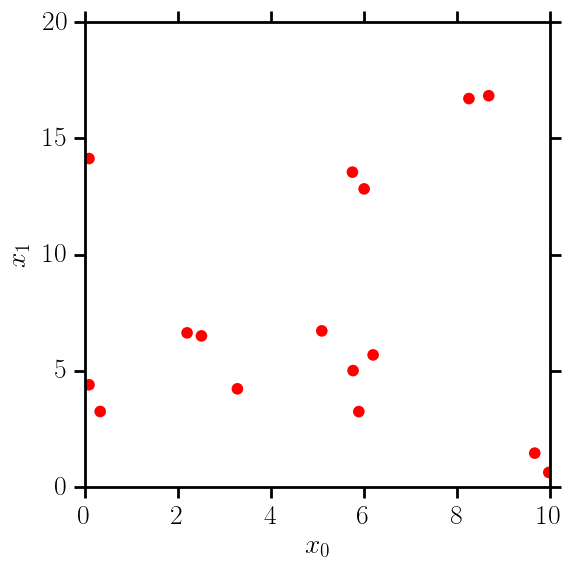

In [723]:
# Make 2d random sampling points
Ndata = 16
limits = np.array([[0, 10], [0, 20]])
points = uniform_random_samples(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [724]:
params = points

# Generate data
def func(x, y):
    return 0.1*x*np.sin(x) + 0.02*y**2

data = np.array([func(params[i, 0], params[i, 1]) for i in range(len(params))])

# Construct Gaussian process
hyperparams = np.array([4.0, 0.01, 5.0, 5.0])
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams)
gp.ln_like()

-25.875698364379133

In [725]:
gpset = GaussianProcessSet(params, data, squared_exponential_covariance)
hyperparams_opt = gpset.optimize(np.log10(hyperparams))
print hyperparams_opt

[  4.17328619   0.04638034   3.8511845   15.54506583]


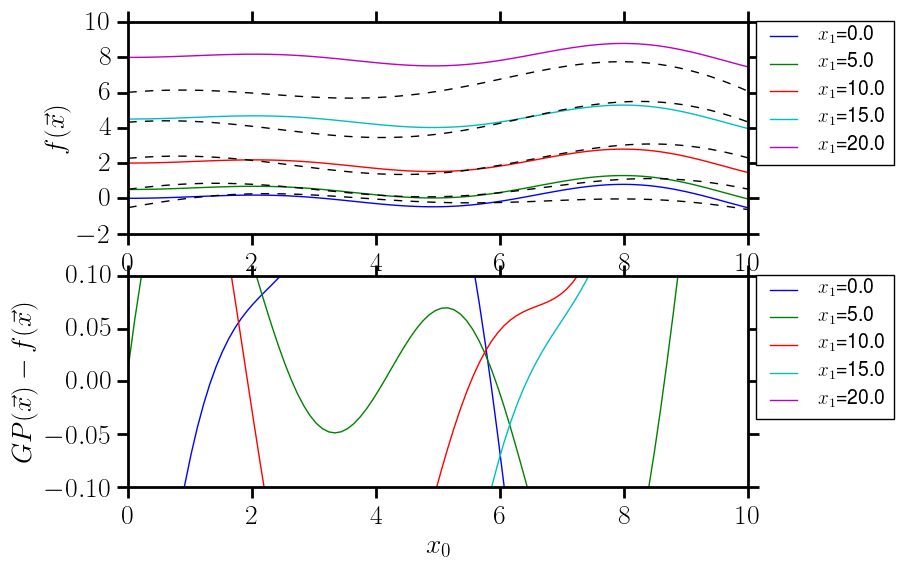

In [726]:
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams_opt)

fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    interp = np.array([gp(p) for p in ps])
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Uniform grid

(4, 4, 2)


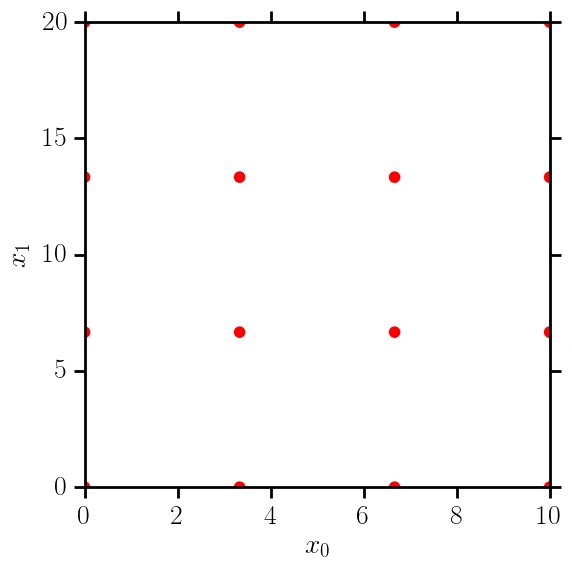

In [728]:
# Make 2d grid of points
limits = np.array([[0, 10], [0, 20]])
points_grid = np.array([[[x0, x1] for x1 in np.linspace(0, 20, 4)] for x0 in np.linspace(0, 10, 4)])
print points_grid.shape
points = points_grid.reshape((4**2, 2))

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [729]:
params = points

# Generate data
def func(x, y):
    return 0.1*x*np.sin(x) + 0.02*y**2

data = np.array([func(params[i, 0], params[i, 1]) for i in range(len(params))])

# Construct Gaussian process
hyperparams = np.array([10.0, 0.1, 10.0, 3.0])
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams)
gp.ln_like()

-34.298467102988603

In [730]:
gpset = GaussianProcessSet(params, data, squared_exponential_covariance)
hyperparams_opt = gpset.optimize(np.log10(hyperparams))
print hyperparams_opt

[  9.13233661   0.24082823  29.83358972  22.18045666]


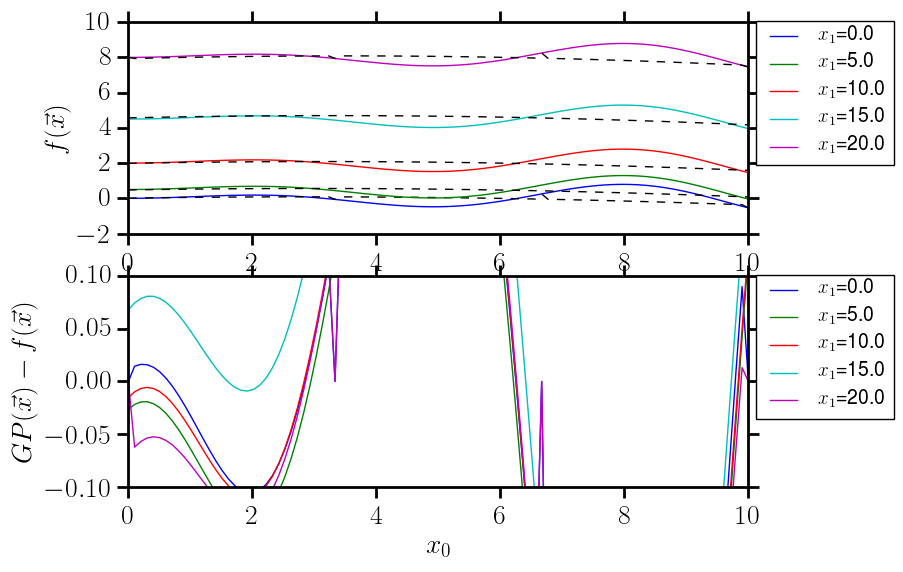

In [731]:
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams_opt)

fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    interp = np.array([gp(p) for p in ps])
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# 5d

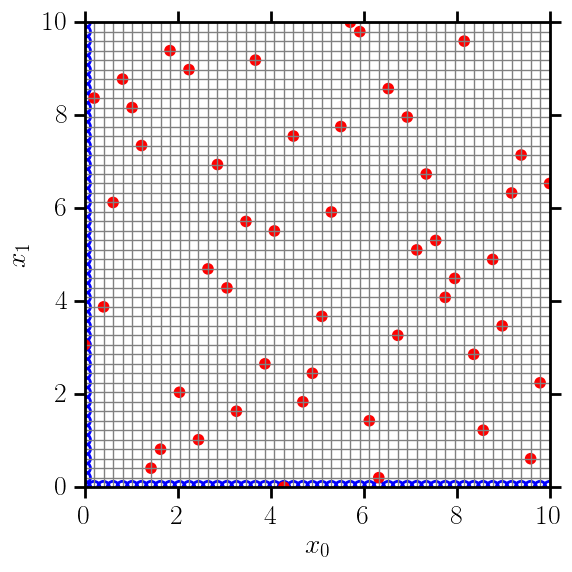

In [834]:
# Make 5d latin hypercube points
Ndata = 50
limits = np.array([[0, 10], [0, 10], [0, 10], [0, 10], [0, 10]])
points = latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

for p in points[:, 0]:
    axes.axvline(p, c='grey', lw=1)

for p in points[:, 1]:
    axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [821]:
# # Make 5d latin hypercube points
# Ndata = 1000
# limits = np.array([[0, 10], [0, 10], [0, 10], [0, 10], [0, 10]])
# points = latin_hypercube(Ndata, limits)

In [841]:
params = points

# Generate data
# def func(x):
#     return 0.1*x[0]*np.sin(x[0]) + 0.02*x[1]**2 + 0.1*x[2]*np.sin(x[2]) + 0.1*x[3]*np.sin(x[3]) + 0.1*x[4]*np.sin(x[4])
def func(x):
    return 0.1*x[0]*np.sin(x[0]) + 0.02*x[1]**2 + 0.02*x[2]**2 + 0.02*x[3]**2 + 0.02*x[4]**2

data = np.array([func(p) for p in params])

# Construct Gaussian process
hyperparams = np.array([4.0, 1.0e-4, 3.0, 3.1, 3.0, 3.0, 3.0])
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams)
gp.ln_like()

-113.07008530134979

In [837]:
data.min(), data.max()

(0.7986120734249238, 6.0586500560521896)

In [842]:
gpset = GaussianProcessSet(params, data, squared_exponential_covariance)
hyperparams_opt = gpset.optimize(np.log10(hyperparams))
print hyperparams_opt

[  7.16234477e+00   1.00108239e-04   3.84184254e+00   2.27245857e+01
   2.22299334e+01   2.36133576e+01   2.36806994e+01]


In [870]:
# Redo with new set of data but optimized hyperparameters
# Make 5d latin hypercube points
Ndata = 200
limits = np.array([[0, 10], [0, 10], [0, 10], [0, 10], [0, 10]])
params = latin_hypercube(Ndata, limits)

data = np.array([func(p) for p in params])

# Construct Gaussian process
gp_opt = GaussianProcess(params, data, squared_exponential_covariance, hyperparams_opt)
gp_opt.ln_like()

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/ipykernel/__main__.py:79: RuntimeWarning: divide by zero encountered in log


inf

In [859]:
# validation set
Ndata = 100
limits = np.array([[0, 10], [0, 10], [0, 10], [0, 10], [0, 10]])
vps = uniform_random_samples(Ndata, limits)

In [860]:
#gp_opt = GaussianProcess(params, data, squared_exponential_covariance, hyperparams_opt)

In [866]:
vps_data = np.array([func(p) for p in vps])
gpps_data = np.array([gp_opt(p) for p in vps])
#gpps_data = np.array([gp(p) for p in vps])

In [867]:
np.min(vps_data), np.max(vps_data)

(-0.020649898226980677, 6.7947618474610341)

In [868]:
frange = np.max(vps_data) - np.min(vps_data)

In [869]:
np.max(np.abs(gpps_data - vps_data)) / frange

0.081595168509391885